In [41]:
# -*- coding: utf-8 -*-
"""
Interactive Phonon Dispersion + Eigenvector Visualizer
Author: Han-Hsuan Wu
"""

import numpy as np
import matplotlib.pyplot as plt
import time
from mpl_toolkits.mplot3d import Axes3D  # for 3D lattice plotting
from ipywidgets import interact, IntSlider, FloatSlider
from ase.io import read  # for POSCAR parsing (uses ASE)


# ===============================
# 1. File Parsers
# ===============================

def parse_band_yaml(filename="band.yaml"):
    
    import re

    start_time = time.time()

    with open(filename, "r") as f:
        text = f.read()

    # Find all q-point headers and their positions
    qpos_iter = list(re.finditer(r'(?m)^\s*-\s*q-position:\s*\[\s*([^\]]+)\]', text))
    if not qpos_iter:
        raise ValueError('Could not find any "q-position" entries in band.yaml')

    nqpoints = len(qpos_iter)

    # Extract q-point coordinates
    qpoints = np.empty((nqpoints, 3), dtype=np.float64)
    for qi, m in enumerate(qpos_iter):
        vals = [float(x) for x in m.group(1).split(",")]
        if len(vals) != 3:
            raise ValueError("q-position does not have 3 components")
        qpoints[qi] = vals

    # Build spans for each q-point section
    spans = []
    for i, m in enumerate(qpos_iter):
        start = m.end()
        end = qpos_iter[i + 1].start() if (i + 1) < nqpoints else len(text)
        spans.append((start, end))

    # Determine nbands and natoms from the first q-point section
    first_section = text[spans[0][0] : spans[0][1]]

    # Count bands in first section by counting frequency entries
    band_matches_first = list(re.finditer(r'(?m)^\s*frequency:\s*([-\d.+Ee]+)', first_section))
    nbands = len(band_matches_first)
    if nbands == 0:
        raise ValueError('Could not determine "nbands" from frequency entries')

    # Extract first eigenvector block and count atoms
    first_ev_block_match = re.search(
        r'(?ms)eigenvector:\s*(.*?)(?=^\s*frequency:|\Z)', first_section
    )
    if not first_ev_block_match:
        raise ValueError('Could not find "eigenvector" block in first q-point section')

    first_ev_block = first_ev_block_match.group(1)
    natoms = len(re.findall(r'(?m)^\s*-\s*#\s*atom', first_ev_block))
    if natoms == 0:
        # Fallback: count complex pairs, divide by 3 components per atom
        pairs_first = re.findall(r'\[\s*([-\d.+Ee]+)\s*,\s*([-\d.+Ee]+)\s*\]', first_ev_block)
        if len(pairs_first) % 3 != 0:
            raise ValueError("Could not infer natoms from eigenvector pairs")
        natoms = len(pairs_first) // 3

    # Pre-allocate arrays
    print(f"Data dimensions: {nqpoints} q-points, {nbands} bands, {natoms} atoms")
    qpoints_array = qpoints
    frequencies = np.empty((nqpoints, nbands), dtype=np.float64)
    eigenvectors = np.empty((nqpoints, nbands, natoms, 3), dtype=np.complex128)

    # Helper regex for band blocks within a q-point section:
    # capture frequency and the following eigenvector block
    band_block_re = re.compile(
        r'(?ms)^\s*frequency:\s*([-\d.+Ee]+)\s*.*?\beigenvector:\s*(.*?)(?=^\s*frequency:|\Z)'
    )

    # Parse all sections
    for qi, (s, e) in enumerate(spans):
        section = text[s:e]
        band_index = 0
        for bm in band_block_re.finditer(section):
            freq_str = bm.group(1)
            frequencies[qi, band_index] = float(freq_str) * 4.14 #THz to meV
            ev_block = bm.group(2)

            # Extract all [real, imag] pairs in order
            pairs = re.findall(r'\[\s*([-\d.+Ee]+)\s*,\s*([-\d.+Ee]+)\s*\]', ev_block)
            if len(pairs) < natoms * 3:
                raise ValueError(
                    f"Not enough eigenvector components at q={qi}, band={band_index}"
                )

            # Fill eigenvectors in the order: atoms x (x,y,z)
            for idx in range(natoms * 3):
                a = idx // 3
                c = idx % 3
                re_part = float(pairs[idx][0])
                im_part = float(pairs[idx][1])
                eigenvectors[qi, band_index, a, c] = re_part + 1j * im_part

            band_index += 1

        if band_index != nbands:
            raise ValueError(f"Expected {nbands} bands, found {band_index} at q-index {qi}")

    yaml_load_time = time.time()
    print(f"Text parsing took: {yaml_load_time - start_time:.2f} seconds")

    return qpoints_array, frequencies, eigenvectors


def parse_poscar(filename="POSCAR"):
    """Parse POSCAR using ASE."""
    atoms = read(filename)
    return atoms


# ===============================
# 2. Plotting
# ===============================

def plot_dispersion(qpoints, frequencies):
    """Plot phonon dispersion curve."""
    plt.figure(figsize=(6,4))
    for band in range(frequencies.shape[1]):
        plt.plot(range(len(qpoints)), frequencies[:, band], 'k-')
    plt.xlabel("Q-point index")
    plt.ylabel("Frequency (THz)")
    plt.title("Phonon Dispersion")
    plt.show()


def plot_eigenvectors(atoms, eigvecs, scale=1.0, expand_cell=(1, 1, 1), plane="xz", 
                        show_vectors=True, show_cell=True, numbering=False, cell_boundary=False, 
                        colors=None,atom_scale=0.45,legend=True,
                        head_width=0.1, head_length=0.1, arrow_linewidth=1,
                        z_range=None
                        ):
    """
    Plot phonon eigenvectors overlaid on a 2D projection of the crystal structure.
    Credit to abTEM show_atoms function
    
    Parameters:
    -----------
    atoms : ASE Atoms object
        The crystal structure
    eigvecs : numpy array
        The eigenvectors for the phonon mode, shape (n_atoms, 3)
    scale : float
        Scaling factor for eigenvector arrows
    expand_cell : tuple
        Cell expansion factors (nx, ny, nz)
    plane : str
        Projection plane ("xy", "xz", or "yz")
    show_vectors : bool
        Whether to show eigenvector arrows
    show_cell : bool
        Whether to show unit cell boundaries
    numbering : bool
        Whether to show atom indices
    cell_boundary : bool
        Whether to show cell boundary lines
    z_range : tuple or None
        If tuple (z_min, z_max), only plot atoms within this z-coordinate range.
        If None, plot all atoms.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.patches import Circle
    from matplotlib.collections import PatchCollection
    from matplotlib.lines import Line2D
    from ase.data import covalent_radii, chemical_symbols
    
    # Store original number of atoms before expansion
    original_n_atoms = len(atoms)
    
    # Expand the atoms structure
    atoms = atoms * expand_cell
    
    # Get atomic data from expanded structure
    positions = atoms.get_positions()
    symbols = atoms.get_chemical_symbols()
    numbers = atoms.get_atomic_numbers()
    
    # Apply z-range filter if specified
    if z_range is not None:
        z_min, z_max = z_range
        z_coords = positions[:, 2]  # z is always the third coordinate
        z_mask = (z_coords >= z_min) & (z_coords <= z_max)
        
        # Filter all arrays based on z_mask
        positions = positions[z_mask]
        symbols = [symbols[i] for i, keep in enumerate(z_mask) if keep]
        numbers = numbers[z_mask]
        
        print(f"Filtered to {len(positions)} atoms within z-range [{z_min:.2f}, {z_max:.2f}] Å")
        print(f"Original z-range: [{z_coords.min():.2f}, {z_coords.max():.2f}] Å")
    
    # Expand eigenvectors to match the expanded cell
    if eigvecs is not None and show_vectors:
        eigvecs = np.array(eigvecs)
        if eigvecs.ndim == 1:
            # If 1D, reshape to (n_atoms, 3)
            eigvecs = eigvecs.reshape(-1, 3)
        elif eigvecs.ndim > 2:
            # If more than 2D, take the first mode
            eigvecs = eigvecs.reshape(-1, 3)
        
        # Check if eigenvectors match original unit cell
        if eigvecs.shape[0] == original_n_atoms:
            # Replicate eigenvectors for expanded cell
            nx, ny, nz = expand_cell
            expanded_eigvecs = []
            
            # For each cell repetition, add the same eigenvectors
            for iz in range(nz):
                for iy in range(ny):
                    for ix in range(nx):
                        expanded_eigvecs.append(eigvecs)
            
            eigvecs = np.vstack(expanded_eigvecs)
        
        # Apply z-range filter to eigenvectors if specified
        if z_range is not None:
            if eigvecs.shape[0] == len(z_mask):
                eigvecs = eigvecs[z_mask]
            else:
                print(f"Warning: eigvecs shape {eigvecs.shape} doesn't match expanded atoms after filtering")
                print("Cannot plot eigenvectors: dimension mismatch")
                show_vectors = False
        elif eigvecs.shape[0] != len(positions):
            print(f"Warning: eigvecs shape {eigvecs.shape} doesn't match expanded atoms {len(positions)}")
            print("Cannot plot eigenvectors: dimension mismatch")
            show_vectors = False
    
    # Check if we have any atoms left after filtering
    if len(positions) == 0:
        print("No atoms found in the specified z-range!")
        return
    
    # Create figure
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Choose projection plane
    if plane == "xy":
        axes = [0, 1, 2]  # x, y, z indices
        xlabel, ylabel = "x [Å]", "y [Å]"
    elif plane == "xz":
        axes = [0, 2, 1]  # x, z, y indices
        xlabel, ylabel = "x [Å]", "z [Å]"
    elif plane == "yz":
        axes = [1, 2, 0]  # y, z, x indices
        xlabel, ylabel = "y [Å]", "z [Å]"
    
    # Get 2D positions for the chosen plane
    positions_2d = positions[:, axes[:2]]
    
    # Sort atoms by depth (z-coordinate) for proper layering
    order = np.argsort(-positions[:, axes[2]])
    positions_2d = positions_2d[order]
    ordered_numbers = numbers[order]
    ordered_symbols = [symbols[i] for i in order]
    
    unique_symbols = sorted(set(symbols))
    if colors is None:
        # Create color mapping for different elements
        colormap = plt.cm.Set3
        color_map = {sym: colormap(i / len(unique_symbols)) for i, sym in enumerate(unique_symbols)}
        colors = [color_map[sym] for sym in ordered_symbols]
    else:
        # Use custom colors dictionary
        colormap = plt.cm.Set3  # fallback for missing elements
        color_map = {}
        for i, sym in enumerate(unique_symbols):
            if sym in colors:
                color_map[sym] = colors[sym]
            else:
                # Use default color for elements not specified in colors dict
                color_map[sym] = colormap(i / len(unique_symbols))
                print(f"Warning: No color specified for element '{sym}', using default color")

    # Create color list for ordered symbols
    atom_colors = [color_map[sym] for sym in ordered_symbols]

    # Scale factor for atom sizes
    atom_scale = atom_scale
    sizes = covalent_radii[ordered_numbers] * atom_scale
    
    # Create circles for atoms
    circles = []
    for position, size in zip(positions_2d, sizes):
        circles.append(Circle(position, size))
    
    # Add circles to plot with proper styling
    coll = PatchCollection(circles, facecolors=atom_colors, edgecolors="black", linewidths=1)
    ax.add_collection(coll)
    
    # Add eigenvector arrows if requested
    if show_vectors and eigvecs is not None:
        for i, pos in enumerate(positions):
            vec = np.real(eigvecs[i]) * scale
            # Project vector to 2D plane
            vec_2d = vec[axes[:2]]
            pos_2d = pos[axes[:2]]
            
            # Only draw arrow if vector has non-zero magnitude
            if np.linalg.norm(vec_2d) > 1e-10:
                ax.arrow(pos_2d[0], pos_2d[1], vec_2d[0], vec_2d[1], 
                        head_width=head_width, head_length=head_length, fc='red', ec='red', 
                        linewidth=arrow_linewidth, alpha=0.8)
    
    # Set equal aspect ratio and labels
    ax.set_aspect('equal')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    # Update title to show z-range if filtered
    if z_range is not None:
        ax.set_title(f"Phonon Mode Eigenvectors (z: {z_range[0]:.1f} - {z_range[1]:.1f} Å)")
    else:
        ax.set_title("Phonon Mode Eigenvectors")
    
    # Add legend showing different atomic species
    legend_elements = [
        Line2D(
            [0], [0],
            marker="o",
            color="w",
            markeredgecolor="k",
            label=sym,
            markerfacecolor=color_map[sym],
            markersize=12,
        )
        for sym in unique_symbols
    ]
    if legend:
        ax.legend(handles=legend_elements, loc="upper right")
    
    # Add atom numbering if requested
    if numbering:
        for i, (position, size) in enumerate(zip(positions_2d, sizes)):
            ax.annotate(
                f"{order[i]}", 
                xy=position, 
                ha="center", 
                va="center",
                fontsize=8,
                fontweight='bold'
            )
    
    # Show unit cell boundaries if requested
    if show_cell and hasattr(atoms, 'cell'):
        cell = atoms.cell
        if not np.allclose(cell, 0):  # Check if cell is defined
            # Define cube edges for 3D cell
            cube_edges = np.array([
                [[0, 0, 0], [1, 0, 0]], [[1, 0, 0], [1, 1, 0]], 
                [[1, 1, 0], [0, 1, 0]], [[0, 1, 0], [0, 0, 0]],
                [[0, 0, 1], [1, 0, 1]], [[1, 0, 1], [1, 1, 1]], 
                [[1, 1, 1], [0, 1, 1]], [[0, 1, 1], [0, 0, 1]],
                [[0, 0, 0], [0, 0, 1]], [[1, 0, 0], [1, 0, 1]], 
                [[1, 1, 0], [1, 1, 1]], [[0, 1, 0], [0, 1, 1]]
            ])
            
            # Transform to real coordinates and project to 2D
            cell_lines = np.array([
                [np.dot(edge[0], cell), np.dot(edge[1], cell)] 
                for edge in cube_edges
            ])
            
            # Project to chosen plane
            cell_lines_2d = cell_lines[:, :, axes[:2]]
            
            # Draw cell boundaries
            if cell_boundary:
                for line in cell_lines_2d:
                    ax.plot(line[:, 0], line[:, 1], 'k-', alpha=0.4, linewidth=1)
    
    # Adjust plot limits to fit all atoms with some padding
    if len(positions_2d) > 0:
        margin = max(sizes) * 1.5
        x_min, x_max = positions_2d[:, 0].min() - margin, positions_2d[:, 0].max() + margin
        y_min, y_max = positions_2d[:, 1].min() - margin, positions_2d[:, 1].max() + margin
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
    
    plt.tight_layout()
    plt.show()

# ===============================
# 3. Interactive Controls
# ===============================

def interactive_viewer(qpoints, frequencies, eigenvectors, atoms, scale=2.0, expand_cell=(1, 1, 1), q_index=0, band_index=0, colors=None, legend=True,
                        head_width=0.1, arrow_linewidth=0.1, z_range=None):
    """Interactive widget to explore phonon modes."""

    def view_mode(q_index=0, band_index=0,head_width=head_width, arrow_linewidth=arrow_linewidth,scale=scale):
        plt.figure(figsize=(6,4))
        for band in range(frequencies.shape[1]):
            plt.plot(range(len(qpoints)), frequencies[:, band], 'k-', alpha=0.3)
        plt.plot(q_index, frequencies[q_index, band_index], 'ro', markersize=10)
        plt.xlabel("Q-point index")
        plt.ylabel("Frequency (THz)")
        plt.title(f"Phonon Dispersion (selected mode {frequencies[q_index, band_index]:.2f} meV)")
        plt.show()

        # plot eigenvectors
        eigvecs = eigenvectors[q_index, band_index]
        plot_eigenvectors(atoms, eigvecs, scale=scale,expand_cell=expand_cell,colors=colors,legend=legend,
                          head_width=head_width, arrow_linewidth=arrow_linewidth, z_range=z_range)

    interact(view_mode,
             q_index=IntSlider(min=0, max=len(qpoints)-1, step=1, value=q_index),
             band_index=IntSlider(min=0, max=frequencies.shape[1]-1, step=1, value=band_index),
             head_width=FloatSlider(min=0.1, max=0.5, step=0.1, value=head_width),
             arrow_linewidth=FloatSlider(min=1, max=5, step=1, value=arrow_linewidth),
             scale=FloatSlider(min=1, max=10.0, step=0.1, value=scale),
            )

In [2]:
import os
path = r"C:\Users\hanhsuan\Desktop\New folder"
print("Load band.yaml and POSCAR")
qpoints, freqs, eigvecs = parse_band_yaml(os.path.join(path, "band-twin-4.yaml")) #band-twin-4.yaml
atoms = parse_poscar(os.path.join(path, "POSCAR"))
# Step 1: quick dispersion plot
# plot_dispersion(qpoints, freqs)

Load band.yaml and POSCAR
Data dimensions: 707 q-points, 144 bands, 48 atoms
Text parsing took: 65.80 seconds


In [45]:
# Step 2: start interactive viewer (in Jupyter)
colors={    'B': 'blue',           # Silicon in blue
            'As': 'lime',  }
twin_z=((atoms.get_positions()[:,2].max()+3*atoms.get_positions()[:,2].min())/4,(3*atoms.get_positions()[:,2].max()+atoms.get_positions()[:,2].min())/4)
interactive_viewer(qpoints, freqs, eigvecs, atoms,expand_cell=(5, 1, 1), 
                    q_index=200, band_index=120, colors=colors,legend=False, 
                    scale = 5.6, head_width=0.2, arrow_linewidth=3.0,
                    z_range=twin_z
                    )

interactive(children=(IntSlider(value=200, description='q_index', max=706), IntSlider(value=120, description='…

Filtered to 120 atoms within z-range [17.07, 49.13] Å
Original z-range: [1.04, 65.16] Å


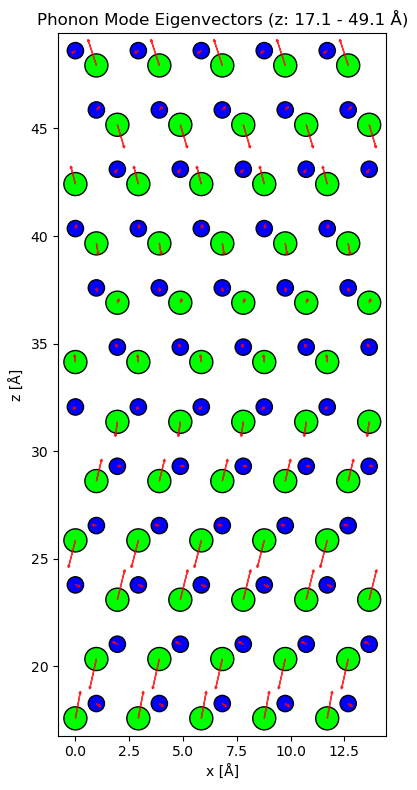

In [40]:
def plot_eigenvectors(atoms, eigvecs, scale=1.0, expand_cell=(1, 1, 1), plane="xz", 
                        show_vectors=True, show_cell=True, numbering=False, cell_boundary=False, 
                        colors=None,atom_scale=0.45,legend=True,
                        head_width=0.1, head_length=0.1, arrow_linewidth=1,
                        z_range=None
                        ):
    """
    Plot phonon eigenvectors overlaid on a 2D projection of the crystal structure.
    Credit to abTEM show_atoms function
    
    Parameters:
    -----------
    atoms : ASE Atoms object
        The crystal structure
    eigvecs : numpy array
        The eigenvectors for the phonon mode, shape (n_atoms, 3)
    scale : float
        Scaling factor for eigenvector arrows
    expand_cell : tuple
        Cell expansion factors (nx, ny, nz)
    plane : str
        Projection plane ("xy", "xz", or "yz")
    show_vectors : bool
        Whether to show eigenvector arrows
    show_cell : bool
        Whether to show unit cell boundaries
    numbering : bool
        Whether to show atom indices
    cell_boundary : bool
        Whether to show cell boundary lines
    z_range : tuple or None
        If tuple (z_min, z_max), only plot atoms within this z-coordinate range.
        If None, plot all atoms.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.patches import Circle
    from matplotlib.collections import PatchCollection
    from matplotlib.lines import Line2D
    from ase.data import covalent_radii, chemical_symbols
    
    # Store original number of atoms before expansion
    original_n_atoms = len(atoms)
    
    # Expand the atoms structure
    atoms = atoms * expand_cell
    
    # Get atomic data from expanded structure
    positions = atoms.get_positions()
    symbols = atoms.get_chemical_symbols()
    numbers = atoms.get_atomic_numbers()
    
    # Apply z-range filter if specified
    if z_range is not None:
        z_min, z_max = z_range
        z_coords = positions[:, 2]  # z is always the third coordinate
        z_mask = (z_coords >= z_min) & (z_coords <= z_max)
        
        # Filter all arrays based on z_mask
        positions = positions[z_mask]
        symbols = [symbols[i] for i, keep in enumerate(z_mask) if keep]
        numbers = numbers[z_mask]
        
        print(f"Filtered to {len(positions)} atoms within z-range [{z_min:.2f}, {z_max:.2f}] Å")
        print(f"Original z-range: [{z_coords.min():.2f}, {z_coords.max():.2f}] Å")
    
    # Expand eigenvectors to match the expanded cell
    if eigvecs is not None and show_vectors:
        eigvecs = np.array(eigvecs)
        if eigvecs.ndim == 1:
            # If 1D, reshape to (n_atoms, 3)
            eigvecs = eigvecs.reshape(-1, 3)
        elif eigvecs.ndim > 2:
            # If more than 2D, take the first mode
            eigvecs = eigvecs.reshape(-1, 3)
        
        # Check if eigenvectors match original unit cell
        if eigvecs.shape[0] == original_n_atoms:
            # Replicate eigenvectors for expanded cell
            nx, ny, nz = expand_cell
            expanded_eigvecs = []
            
            # For each cell repetition, add the same eigenvectors
            for iz in range(nz):
                for iy in range(ny):
                    for ix in range(nx):
                        expanded_eigvecs.append(eigvecs)
            
            eigvecs = np.vstack(expanded_eigvecs)
        
        # Apply z-range filter to eigenvectors if specified
        if z_range is not None:
            if eigvecs.shape[0] == len(z_mask):
                eigvecs = eigvecs[z_mask]
            else:
                print(f"Warning: eigvecs shape {eigvecs.shape} doesn't match expanded atoms after filtering")
                print("Cannot plot eigenvectors: dimension mismatch")
                show_vectors = False
        elif eigvecs.shape[0] != len(positions):
            print(f"Warning: eigvecs shape {eigvecs.shape} doesn't match expanded atoms {len(positions)}")
            print("Cannot plot eigenvectors: dimension mismatch")
            show_vectors = False
    
    # Check if we have any atoms left after filtering
    if len(positions) == 0:
        print("No atoms found in the specified z-range!")
        return
    
    # Create figure
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Choose projection plane
    if plane == "xy":
        axes = [0, 1, 2]  # x, y, z indices
        xlabel, ylabel = "x [Å]", "y [Å]"
    elif plane == "xz":
        axes = [0, 2, 1]  # x, z, y indices
        xlabel, ylabel = "x [Å]", "z [Å]"
    elif plane == "yz":
        axes = [1, 2, 0]  # y, z, x indices
        xlabel, ylabel = "y [Å]", "z [Å]"
    
    # Get 2D positions for the chosen plane
    positions_2d = positions[:, axes[:2]]
    
    # Sort atoms by depth (z-coordinate) for proper layering
    order = np.argsort(-positions[:, axes[2]])
    positions_2d = positions_2d[order]
    ordered_numbers = numbers[order]
    ordered_symbols = [symbols[i] for i in order]
    
    unique_symbols = sorted(set(symbols))
    if colors is None:
        # Create color mapping for different elements
        colormap = plt.cm.Set3
        color_map = {sym: colormap(i / len(unique_symbols)) for i, sym in enumerate(unique_symbols)}
        colors = [color_map[sym] for sym in ordered_symbols]
    else:
        # Use custom colors dictionary
        colormap = plt.cm.Set3  # fallback for missing elements
        color_map = {}
        for i, sym in enumerate(unique_symbols):
            if sym in colors:
                color_map[sym] = colors[sym]
            else:
                # Use default color for elements not specified in colors dict
                color_map[sym] = colormap(i / len(unique_symbols))
                print(f"Warning: No color specified for element '{sym}', using default color")

    # Create color list for ordered symbols
    atom_colors = [color_map[sym] for sym in ordered_symbols]

    # Scale factor for atom sizes
    atom_scale = atom_scale
    sizes = covalent_radii[ordered_numbers] * atom_scale
    
    # Create circles for atoms
    circles = []
    for position, size in zip(positions_2d, sizes):
        circles.append(Circle(position, size))
    
    # Add circles to plot with proper styling
    coll = PatchCollection(circles, facecolors=atom_colors, edgecolors="black", linewidths=1)
    ax.add_collection(coll)
    
    # Add eigenvector arrows if requested
    if show_vectors and eigvecs is not None:
        for i, pos in enumerate(positions):
            vec = np.real(eigvecs[i]) * scale
            # Project vector to 2D plane
            vec_2d = vec[axes[:2]]
            pos_2d = pos[axes[:2]]
            
            # Only draw arrow if vector has non-zero magnitude
            if np.linalg.norm(vec_2d) > 1e-10:
                ax.arrow(pos_2d[0], pos_2d[1], vec_2d[0], vec_2d[1], 
                        head_width=head_width, head_length=head_length, fc='red', ec='red', 
                        linewidth=arrow_linewidth, alpha=0.8)
    
    # Set equal aspect ratio and labels
    ax.set_aspect('equal')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    # Update title to show z-range if filtered
    if z_range is not None:
        ax.set_title(f"Phonon Mode Eigenvectors (z: {z_range[0]:.1f} - {z_range[1]:.1f} Å)")
    else:
        ax.set_title("Phonon Mode Eigenvectors")
    
    # Add legend showing different atomic species
    legend_elements = [
        Line2D(
            [0], [0],
            marker="o",
            color="w",
            markeredgecolor="k",
            label=sym,
            markerfacecolor=color_map[sym],
            markersize=12,
        )
        for sym in unique_symbols
    ]
    if legend:
        ax.legend(handles=legend_elements, loc="upper right")
    
    # Add atom numbering if requested
    if numbering:
        for i, (position, size) in enumerate(zip(positions_2d, sizes)):
            ax.annotate(
                f"{order[i]}", 
                xy=position, 
                ha="center", 
                va="center",
                fontsize=8,
                fontweight='bold'
            )
    
    # Show unit cell boundaries if requested
    if show_cell and hasattr(atoms, 'cell'):
        cell = atoms.cell
        if not np.allclose(cell, 0):  # Check if cell is defined
            # Define cube edges for 3D cell
            cube_edges = np.array([
                [[0, 0, 0], [1, 0, 0]], [[1, 0, 0], [1, 1, 0]], 
                [[1, 1, 0], [0, 1, 0]], [[0, 1, 0], [0, 0, 0]],
                [[0, 0, 1], [1, 0, 1]], [[1, 0, 1], [1, 1, 1]], 
                [[1, 1, 1], [0, 1, 1]], [[0, 1, 1], [0, 0, 1]],
                [[0, 0, 0], [0, 0, 1]], [[1, 0, 0], [1, 0, 1]], 
                [[1, 1, 0], [1, 1, 1]], [[0, 1, 0], [0, 1, 1]]
            ])
            
            # Transform to real coordinates and project to 2D
            cell_lines = np.array([
                [np.dot(edge[0], cell), np.dot(edge[1], cell)] 
                for edge in cube_edges
            ])
            
            # Project to chosen plane
            cell_lines_2d = cell_lines[:, :, axes[:2]]
            
            # Draw cell boundaries
            if cell_boundary:
                for line in cell_lines_2d:
                    ax.plot(line[:, 0], line[:, 1], 'k-', alpha=0.4, linewidth=1)
    
    # Adjust plot limits to fit all atoms with some padding
    if len(positions_2d) > 0:
        margin = max(sizes) * 1.5
        x_min, x_max = positions_2d[:, 0].min() - margin, positions_2d[:, 0].max() + margin
        y_min, y_max = positions_2d[:, 1].min() - margin, positions_2d[:, 1].max() + margin
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
    
    plt.tight_layout()
    plt.show()
# Plot atoms only between z = 10 and z = 50 Å
colors = {'B': 'blue', 'As': 'lime'}
twin_z=((atoms.get_positions()[:,2].max()+3*atoms.get_positions()[:,2].min())/4,(3*atoms.get_positions()[:,2].max()+atoms.get_positions()[:,2].min())/4)
plot_eigenvectors(atoms, eigvecs[50,70], 
                  expand_cell=(5, 1, 1), 
                  scale=5.0, 
                  plane="xz", 
                  show_vectors=True, 
                  show_cell=True, 
                  numbering=False, 
                  cell_boundary=False, 
                  colors=colors, 
                  legend=False,
                  z_range=(twin_z))  # Only plot atoms between z=10 and z=50